<a href="https://colab.research.google.com/github/djdtimit/Deep-Learning/blob/master/pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a pretrained convnet


large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes): ImageNet contains many animal classes, including different species of cats and dogs. Thus, it is expected that it will perform well on the dogs-versus-cats classification problems.

There are two ways to use a pretrained network. feature extraction and fine-tuning.


## Feature extraction

Feature extraction consists of using the representations learned by a prevoius network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

convnets consists of two parts:

- series of pooling and convolution layers -> convolutional base of the model
- end with a densely connected classifier

feature extraction: using the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

Why only reuse the convolutional base?

- representations learned by the convolutional base are likely to be more generic and therefore more reuseable -> contain the object location

- representaions learned by the classifier will be necessarily be specific to the set of classes on which the model was trained -> they will not contain information about where objects are located in the input image

level of generality depends on the depth of the layer in the model:

- earlier layers extract local, highly generic feature maps (edges, colors, and textures)

- higher layers extract more abstract concepts (cat ear or dog eye)

=> if new dataset differs a lot from the dataset on which the original model was trained: better off using only the first few layers do to feature extraction

In [0]:
from keras.applications import VGG16

In [0]:
conv_base = VGG16(weights='imagenet',
                  include_top=False, # not include the classifier
                  input_shape=(150,150,3))

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

two ways to proceed:

- Fast Feature Extraction without data augmentation

- Feature extraction with data augmentation

## Fast feature extraction without data augmentation

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
base_dir = '/content/gdrive/My Drive/Colab Notebooks/dogs_vs_cats/cats_and_dogs_small'

In [0]:
train_dir = os.path.join(base_dir, 'train')

In [0]:
validation_dir = os.path.join(base_dir, 'validation')

In [0]:
test_dir = os.path.join(base_dir, 'test')

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

In [0]:
batch_size = 20

In [0]:
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary'
  )
  i = 0
  for input_batch, labels_batch in generator:
    features_batch = conv_base.predict(input_batch)
    features[i * batch_size : (i+1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

In [0]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [0]:
from keras import models
from keras import layers
from keras import optimizers

In [0]:
model = models.Sequential()
model.add(layers.Dense(units=256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history = model.fit(x=train_features, y = train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 993us/step - loss: 0.7079 - acc: 0.7575 - val_loss: 0.4313 - val_acc: 0.7860
Epoch 2/30
2000/2000 [==============================] - 1s 423us/step - loss: 0.3476 - acc: 0.8540 - val_loss: 0.2607 - val_acc: 0.9010
Epoch 3/30
2000/2000 [==============================] - 1s 422us/step - loss: 0.2831 - acc: 0.8865 - val_loss: 0.2705 - val_acc: 0.8960
Epoch 4/30
2000/2000 [==============================] - 1s 420us/step - loss: 0.2502 - acc: 0.9030 - val_loss: 0.3544 - val_acc: 0.8660
Epoch 5/30
2000/2000 [==============================] - 1s 413us/step - loss: 0.2197 - acc: 0.9200 - val_loss: 0.2951 - val_acc: 0.8950
Epoch 6/30
2000/2000 [==============================] - 1s 431us/step - loss: 0.1904 - acc: 0.9245 - val_loss: 0.2621 - val_acc: 0.9020
Epoch 7/30
2000/2000 [==============================] - 1s 404us/step - loss: 0.1581 - acc: 0.9385 - val_loss: 0.3133 - val_acc: 0.8920


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [0]:
epochs = range(1, len(acc) + 1)

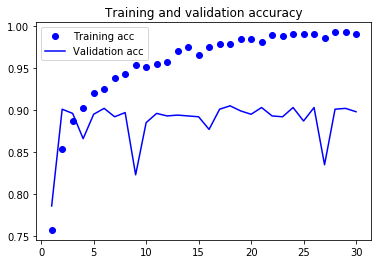

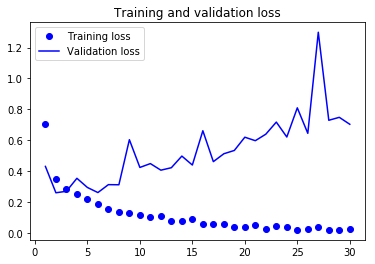

In [0]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

=> overfitting because no data augmentation, which is essential for preventing overfitting on small image datasets

## Feature Extraction with data augmentation

more slower and more expensive but allows data augmentation => should only be used with a GPU

In [0]:
from keras import models
from keras import layers

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Next step: Freezing

Freezing: preventing the weights from being updated during training. Otherwise the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned. => setting trainable attribute to False in Keras

In [12]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [0]:
conv_base.trainable = False

In [15]:
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


Now, only the weights from the two Dense layers will be trained => total of four weight tensors: two per layer (the main weight matrix and the bias vector).

In order for these changes to take effect, the model must be compiled first.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [30]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


In [31]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy', metrics=['acc'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = 50
)

Epoch 1/30
100/100 [==============================] - 1300s 13s/step - loss: 0.5892 - acc: 0.6885 - val_loss: 0.4502 - val_acc: 0.8270
Epoch 2/30
100/100 [==============================] - 20s 197ms/step - loss: 0.4801 - acc: 0.7925 - val_loss: 0.3700 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 20s 198ms/step - loss: 0.4311 - acc: 0.8075 - val_loss: 0.3351 - val_acc: 0.8670
Epoch 4/30
100/100 [==============================] - 19s 195ms/step - loss: 0.4028 - acc: 0.8295 - val_loss: 0.3100 - val_acc: 0.8750
Epoch 5/30
100/100 [==============================] - 19s 194ms/step - loss: 0.3768 - acc: 0.8360 - val_loss: 0.2996 - val_acc: 0.8730
Epoch 6/30
100/100 [==============================] - 19s 194ms/step - loss: 0.3643 - acc: 0.8340 - val_loss: 0.2823 - val_acc: 0.8840
Epoch 7/30
100/100 [==============================] - 19s 193ms/step - loss: 0.3592 - acc: 0.8405 - val_loss: 0.2987 - val_acc: 0.8670
Epoch 8/30
100/100 [==============================] - 2

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

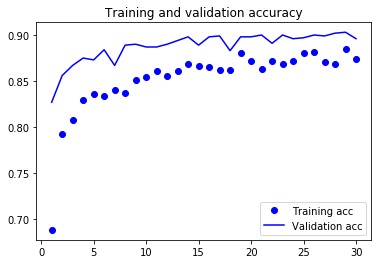

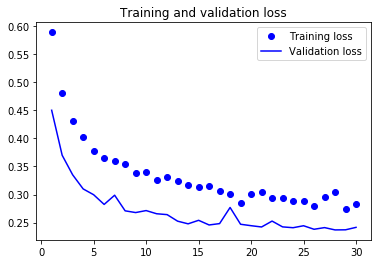

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

Fine-tuning consists of unfreezing a few of the top layers of the frozen model base => training of the unfreezed layers and the fully connected classifier

This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

1. Add the custom network on top of an already-trained base network

2. Freeze the base network

3. Train the added part

4. Unfreeze some layers in the base network

5. Jointly train both these layers and the added part

If the classifier isn't already trained, then the error signal propagating through the network during training will be too large, and the represenations previously learned by the layers being fine-tuned will be destroyed.

In [35]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The layers block5_conv1, block5_conv2 and block5_conv3 should be trainable;

- It's more useful to fine-tune the more specilized top layers, because these are the ones that need to be repurposed on the new problem

- The more parameters are trained, the higher the risk of overfitting

In [0]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5), # low learning rate to limit the magnitude of the modifications
              metrics=['acc'])

In [39]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 22s 221ms/step - loss: 0.2932 - acc: 0.8670 - val_loss: 0.2329 - val_acc: 0.9100
Epoch 2/100
100/100 [==============================] - 20s 199ms/step - loss: 0.2645 - acc: 0.8900 - val_loss: 0.2129 - val_acc: 0.9150
Epoch 3/100
100/100 [==============================] - 20s 197ms/step - loss: 0.2433 - acc: 0.9015 - val_loss: 0.2238 - val_acc: 0.9070
Epoch 4/100
100/100 [==============================] - 20s 197ms/step - loss: 0.2215 - acc: 0.8995 - val_loss: 0.2193 - val_acc: 0.9080
Epoch 5/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2097 - acc: 0.9165 - val_loss: 0.2103 - val_acc: 0.9210
Epoch 6/100
100/100 [==============================] - 20s 198ms/step - loss: 0.2025 - acc: 0.9160 - val_loss: 0.1995 - val_acc: 0.9200
Epoch 7/100
100/100 [==============================] - 20s 196ms/step - loss: 0.1784 - acc: 0.9290 - val_loss: 0.2069 - val_acc: 0.9190
Epoch 8/100
100/100 [===========================

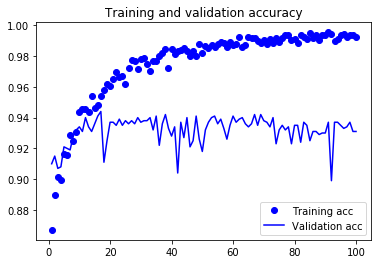

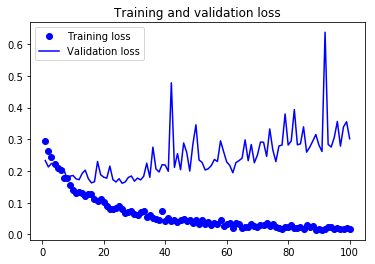

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

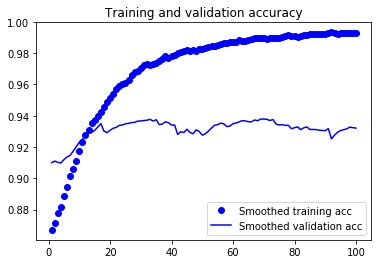

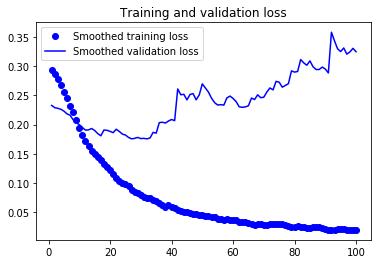

In [43]:
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


In [0]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

In [46]:
print('test_acc:', test_acc)

test_acc: 0.9339999914169311
